In [1]:
# Fashion-MNIST数据集分类

In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import matplotlib.pyplot as plt
import torch.nn as nn

d2l.use_svg_display()

ModuleNotFoundError: No module named 'd2l'

In [ ]:
help(d2l.use_svg_display)

Help on function use_svg_display in module d2l.torch:

use_svg_display()
    Use the svg format to display a plot in Jupyter.
    
    Defined in :numref:`sec_calculus`



## 读取数据集

### torchvision下载数据

In [ ]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64)
])
mnist_train = torchvision.datasets.FashionMNIST("../Data/FashionMNIST", train=True, transform=trans, download=False)
mnist_test = torchvision.datasets.FashionMNIST("../Data/FashionMNIST", train=False, transform=trans, download=False)

In [ ]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [ ]:
# 图片尺寸
mnist_train[0][0].shape

torch.Size([1, 64, 64])

### 图片可视化

In [ ]:
# FashionMNIST的标签
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
    'sneaker', 'bag', 'ankle boot'
]

In [ ]:
# 张量图片转换
def imgConvert(img_tensor):
#     img = img_tensor.to("cpu").clone().detach()
    img = img_tensor.numpy()
    img = img.transpose(1, 2, 0)
    return img

In [ ]:
# 图片展示
def imgShow(imgs, rows, cols, titles=None):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4))
    for i in range(rows * cols):
        ax = axes[i // cols][i % cols]
        img = imgConvert(imgs[i])
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()

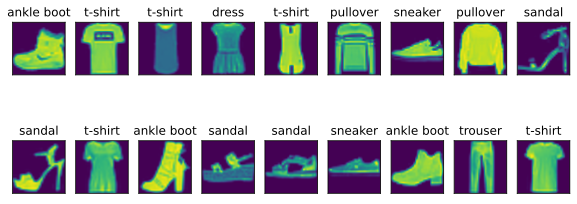

In [ ]:
rows = 2
cols = 9
imgs, labels = next(iter(torch.utils.data.DataLoader(mnist_train, batch_size=rows * cols, shuffle=False)))
titles = [text_labels[label] for label in labels]
imgShow(imgs, rows, cols, titles)

### dataloader制作数据集

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [ ]:
# 读取数据的时间
import time
start = time.time()
for X, y in train_loader:
    continue
print(time.time() - start)

6.711225271224976


In [ ]:
for X, y in train_loader:
    print(X.shape, y.shape)  # X:[batch, c, w h]
    break

torch.Size([32, 1, 64, 64]) torch.Size([32])


## 网络模型

In [ ]:
# 直接展平后过全连接
class SoftMaxNet(nn.Module):
    def __init__(self, input_num, output_num):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_num, output_num)
        )
        
    def forward(self, x):
        x = self.hidden(x)
        return x

In [ ]:
input_num = mnist_train[0][0].shape[1] * mnist_train[0][0].shape[2]
output_num = 10
net = SoftMaxNet(input_num, output_num)

### 权重偏置初始化

In [ ]:
for name, model in net.named_children():
    if type(model) == nn.Sequential:
        for m in model:
            if type(m) == nn.Linear:
                print("原始权重", m.weight.data)
                print("原始偏置", m.bias.data)
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.normal_(m.bias, mean=0, std=0.01)
                print("修改权重", m.weight.data)
                print("修改偏置", m.bias.data)
    elif type[model] == nn.Linear:
        nn.init.normal_(model.weight, mean=0, std=0.01)
        nn.init.normal_(m.bias, mean=0, std=0.01)

原始权重 tensor([[-0.0123, -0.0038,  0.0103,  ...,  0.0030, -0.0152,  0.0116],
        [-0.0151,  0.0072, -0.0138,  ..., -0.0102,  0.0079,  0.0132],
        [ 0.0100,  0.0055,  0.0125,  ..., -0.0021,  0.0066,  0.0082],
        ...,
        [ 0.0083,  0.0119, -0.0037,  ...,  0.0085,  0.0045,  0.0078],
        [-0.0028,  0.0063, -0.0079,  ..., -0.0152,  0.0069, -0.0152],
        [ 0.0032, -0.0032,  0.0016,  ...,  0.0068, -0.0128, -0.0154]])
原始偏置 tensor([-0.0040, -0.0133,  0.0116,  0.0110,  0.0148, -0.0124,  0.0143,  0.0091,
        -0.0134,  0.0059])
修改权重 tensor([[ 0.0106, -0.0080,  0.0188,  ...,  0.0115, -0.0120,  0.0068],
        [ 0.0071, -0.0043,  0.0037,  ..., -0.0022, -0.0018, -0.0083],
        [ 0.0227, -0.0083, -0.0107,  ...,  0.0031, -0.0096, -0.0026],
        ...,
        [ 0.0041,  0.0107,  0.0075,  ...,  0.0054,  0.0051, -0.0055],
        [-0.0064, -0.0061, -0.0293,  ...,  0.0126, -0.0029, -0.0027],
        [-0.0204,  0.0098, -0.0137,  ...,  0.0115, -0.0089, -0.0032]])
修改偏置 tenso

## 损失函数和优化器

In [ ]:
# 'none'代表的是batch内的每个元素都会计算一个损失，返回的结果还是一个batch；
# 'mean’代表的是是否进行平均，一个batch只返回一个；
# 'sum’代表的是将batch内的loss相加，一个batch也是只返回一个；
loss = nn.CrossEntropyLoss(reduction="none")

lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

## 训练

In [ ]:
def train(train_data, test_data, loss, optimizer, epochs):
    for epoch in range(epochs):
        train_loss = 0  # 
        for X, y in train_data:
            net.train()
            print(net(X))
            print(y)
            l = loss(net(X), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        if (epoch + 1) % 1 == 0:
            net.eval()
            for feature, target in test_data:
                loss(net(feature), target)

In [ ]:
# epochs = 10
# train(train_loader, test_loader, loss, optimizer, epochs)

AssertionError: 1.070677595547835

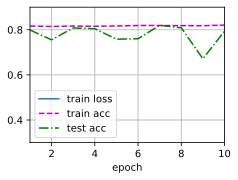

In [ ]:
num_epochs = 10
d2l.train_ch3(net, train_loader, test_loader, loss, num_epochs, optimizer)